<h1>Bước 1: </h1> Cài đặt thư viện

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import cv2
import numpy as np
import tensorflow as tf
from sklearn.metrics import r2_score, mean_squared_error
from keras.preprocessing.image import ImageDataGenerator, load_img
from tqdm.notebook import tqdm
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, GlobalAveragePooling2D, AveragePooling2D
from PIL import Image
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

<h1>Bước 2: </h1> Lấy dữ liệu

In [2]:
BASE_DIR = 'Datas'

In [3]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23684 [00:00<?, ?it/s]

In [4]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,Datas\100_0_0_20170112213500903.jpg.chip.jpg,100,0
1,Datas\100_0_0_20170112215240346.jpg.chip.jpg,100,0
2,Datas\100_1_0_20170110183726390.jpg.chip.jpg,100,1
3,Datas\100_1_0_20170112213001988.jpg.chip.jpg,100,1
4,Datas\100_1_0_20170112213303693.jpg.chip.jpg,100,1


In [5]:
# Gán nhãn giới tính, 0 == Nam, 1 == Nữ
gender_dict = {0:'Nam', 1:'Nữ'}

<h1>Bước 3: </h1> Phân tích dữ liệu

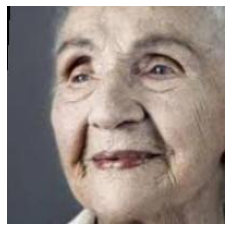

In [6]:
img = Image.open(df['image'][6])
plt.axis('off')
plt.imshow(img)

<AxesSubplot:xlabel='age', ylabel='Density'>

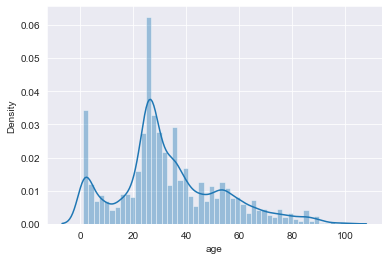

In [7]:
sns.distplot(df['age'])

<AxesSubplot:xlabel='gender', ylabel='count'>

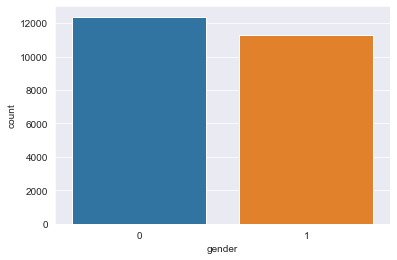

In [8]:
df = df[df['gender'] != 3]
sns.countplot(x=df['gender'], data=df)

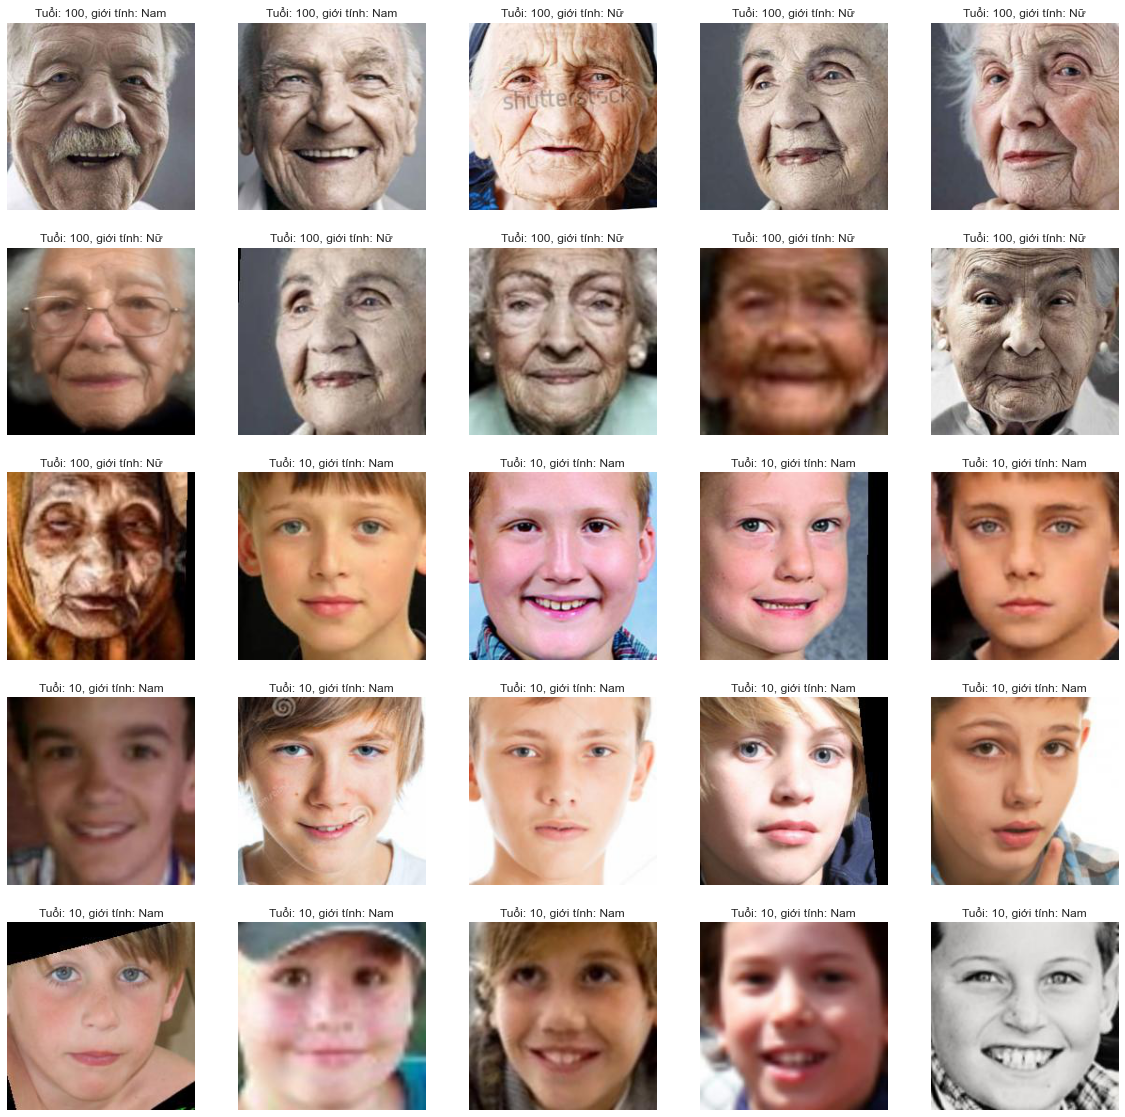

In [9]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Tuổi: {age}, giới tính: {gender_dict[gender]}")
    plt.axis('off')

<h1>Bước 4: </h1> Thực hiện trích xuất đặc trưng

In [10]:
y = []
X = []

len_Image = os.listdir(BASE_DIR)
l = len(len_Image)

for i in range(l):
    X.append(cv2.imread(BASE_DIR+'/'+len_Image[i],0))
    age = int(len_Image[i].split('_')[0])
    # Trẻ nhũ nhi
    if 1 <= age <= 2:
        y.append(0)
    # Tuổi ấu nhi
    elif 3 <= age <= 6:
        y.append(1)
    # Tuổi thiếu nhi
    elif 7 <= age <= 12:
        y.append(2)
    # Tuổi vị thành niên
    elif 13 <= age <= 20:
        y.append(3)
    # Tuổi thanh niên
    elif 21 <= age <= 40:
        y.append(4)
    # Tuổi trung niên
    elif 41 <= age <= 60:
        y.append(5)
    # Tuổi già
    elif 61 <= age <= 80:
        y.append(6)
    # Thọ
    elif 81 <= age <= 116:
        y.append(7)
    print('Loading: ' + str(i)+'/'+str(l))
np.savez_compressed('Compressed_Image_Data.npz',x=X,y=y)

Loading: 0/23684
Loading: 1/23684
Loading: 2/23684
Loading: 3/23684
Loading: 4/23684
Loading: 5/23684
Loading: 6/23684
Loading: 7/23684
Loading: 8/23684
Loading: 9/23684
Loading: 10/23684
Loading: 11/23684
Loading: 12/23684
Loading: 13/23684
Loading: 14/23684
Loading: 15/23684
Loading: 16/23684
Loading: 17/23684
Loading: 18/23684
Loading: 19/23684
Loading: 20/23684
Loading: 21/23684
Loading: 22/23684
Loading: 23/23684
Loading: 24/23684
Loading: 25/23684
Loading: 26/23684
Loading: 27/23684
Loading: 28/23684
Loading: 29/23684
Loading: 30/23684
Loading: 31/23684
Loading: 32/23684
Loading: 33/23684
Loading: 34/23684
Loading: 35/23684
Loading: 36/23684
Loading: 37/23684
Loading: 38/23684
Loading: 39/23684
Loading: 40/23684
Loading: 41/23684
Loading: 42/23684
Loading: 43/23684
Loading: 44/23684
Loading: 45/23684
Loading: 46/23684
Loading: 47/23684
Loading: 48/23684
Loading: 49/23684
Loading: 50/23684
Loading: 51/23684
Loading: 52/23684
Loading: 53/23684
Loading: 54/23684
Loading: 55/23684
Lo

In [11]:
loaded = np.load('Compressed_Image_Data.npz')
X = loaded['x']
y = loaded['y']

In [12]:
y = np_utils.to_categorical(y)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train = np.array(X_train).reshape(-1, 200, 200, 1)
X_test = np.array(X_test).reshape(-1, 200, 200, 1)

In [14]:
IMG_HEIGHT = 200
IMG_WIDTH = 200
IMG_SIZE = (IMG_HEIGHT,IMG_WIDTH)
batch_size = 128
epochs = 60

In [15]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1,
    rotation_range = 15
)

test_datagen = ImageDataGenerator(rescale = 1./255)

<h1>Bước 5: </h1> Huấn luyện

In [ ]:
train_data = train_datagen.flow(X_train, y_train, batch_size)
test_data = test_datagen.flow(X_test, y_test, batch_size)

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=5, activation='relu', input_shape=(200, 200, 1)))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(132, activation='relu'))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
checkpoint = ModelCheckpoint(
    filepath="Model.h5",
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [ ]:
history = model.fit(
    train_data,
    batch_size=batch_size,
    validation_data=test_data,
    epochs=epochs,
    callbacks=[checkpoint],
    shuffle=False
)

In [ ]:
plotting_data_dict = history.history
plt.figure(figsize=(12,8))
test_loss = plotting_data_dict['val_loss']
training_loss = plotting_data_dict['loss']
test_accuracy = plotting_data_dict['val_accuracy']
training_accuracy = plotting_data_dict['accuracy']
epochs = range(1,len(test_loss)+1)
plt.subplot(121)
plt.plot(epochs,test_loss,marker='X',label='test_loss')
plt.plot(epochs,training_loss,marker='X',label='training_loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs,test_accuracy,marker='X',label='test_accuracy')
plt.plot(epochs,training_accuracy,marker='X',label='training_accuracy')
plt.legend()
plt.savefig('Model_Training.png')

<h1>Bước 6: </h1> Đánh giá độ chính xác

In [ ]:
# Dự đoán nhãn của dữ liệu kiểm tra
y_pred = model.predict_classes(X_test)
# Chuyển đổi nhãn từ dạng one-hot vector sang dạng số nguyên
y_test_int = np.argmax(y_test, axis=1)
# Tính toán MSE
mse = mean_squared_error(y_test_int, y_pred)
# Tính toán R2 score
r2 = r2_score(y_test_int, y_pred)
print("MSE:", mse)
print("R2 score:", r2)